In [2]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math
from collections import Counter
import heapq


In [5]:
#Read Image
img_path = r"/content/drive/MyDrive/FDIP/Assignment7/abstract.jpg"   # change path
img = np.array(Image.open(img_path).convert('RGB'))
H, W, _ = img.shape
print("Original image shape:", img.shape)

#RGB → YCbCr
img = img.astype(np.float32)
R, G, B = img[...,0], img[...,1], img[...,2]
Y  = 0.299*R + 0.587*G + 0.114*B
Cb = -0.16874*R - 0.33126*G + 0.5*B + 128
Cr = 0.5*R - 0.41869*G - 0.08131*B + 128

# Pad image so H and W are multiples of 8
H_pad = (H + 7) // 8 * 8
W_pad = (W + 7) // 8 * 8
pad_img = np.zeros((H_pad, W_pad, 3), dtype=img.dtype)
pad_img[:H, :W, :] = img
img = pad_img
H, W, _ = img.shape
print("Padded image shape:", img.shape)

Original image shape: (2159, 3840, 3)
Padded image shape: (2160, 3840, 3)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


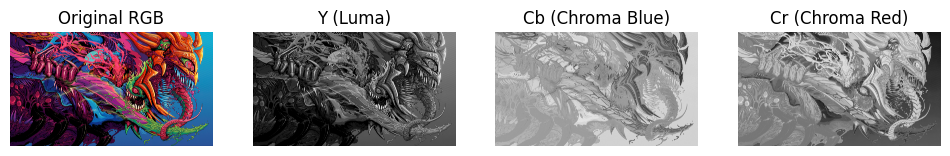

In [7]:
#Normalize Y, Cb, Cr for display
Y_disp  = np.clip(Y, 0, 255).astype(np.uint8)
Cb_disp = np.clip(Cb, 0, 255).astype(np.uint8)
Cr_disp = np.clip(Cr, 0, 255).astype(np.uint8)

#Stack as pseudo-color image
ycbcr_img = np.stack([Y_disp, Cb_disp, Cr_disp], axis=-1)

# -------- Show RGB vs YCbCr --------
plt.figure(figsize=(12,6))
plt.subplot(1,4,1); plt.imshow(img.astype(np.uint8)); plt.title("Original RGB"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(Y_disp, cmap="gray"); plt.title("Y (Luma)"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(Cb_disp, cmap="gray"); plt.title("Cb (Chroma Blue)"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(Cr_disp, cmap="gray"); plt.title("Cr (Chroma Red)"); plt.axis("off")
plt.show()


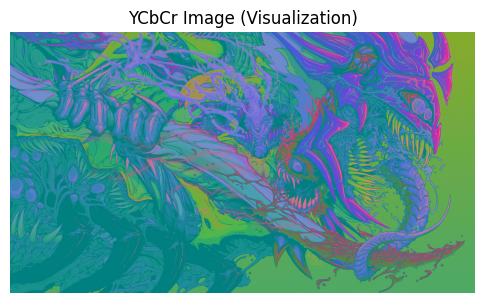

In [8]:
# -------- Create YCbCr image (for visualization only) --------
Y_norm  = np.clip(Y, 0, 255).astype(np.uint8)
Cb_norm = np.clip(Cb, 0, 255).astype(np.uint8)
Cr_norm = np.clip(Cr, 0, 255).astype(np.uint8)

ycbcr_img = np.stack([Y_norm, Cb_norm, Cr_norm], axis=-1)

# -------- Show YCbCr as single image --------
plt.figure(figsize=(6,6))
plt.imshow(ycbcr_img)
plt.title("YCbCr Image (Visualization)")
plt.axis("off")
plt.show()


In [9]:
QY = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,58,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]
])

QC = np.array([
 [17,18,24,47,99,99,99,99],
 [18,21,26,66,99,99,99,99],
 [24,26,56,99,99,99,99,99],
 [47,66,99,99,99,99,99,99],
 [99,99,99,99,99,99,99,99],
 [99,99,99,99,99,99,99,99],
 [99,99,99,99,99,99,99,99],
 [99,99,99,99,99,99,99,99]
])


In [10]:
# Precompute the zigzag order for an 8x8 block
zigzag_order = [
 0,  1,  5,  6, 14, 15, 27, 28,
 2,  4,  7, 13, 16, 26, 29, 42,
 3,  8, 12, 17, 25, 30, 41, 43,
 9, 11, 18, 24, 31, 40, 44, 53,
10, 19, 23, 32, 39, 45, 52, 54,
20, 22, 33, 38, 46, 51, 55, 60,
21, 34, 37, 47, 50, 56, 59, 61,
35, 36, 48, 49, 57, 58, 62, 63
]

def zigzag(block):
    block_flat = block.flatten()
    return np.array([block_flat[i] for i in zigzag_order])

def izigzag(arr):
    block = np.zeros(64, dtype=int)
    for i, val in enumerate(arr):
        block[zigzag_order[i]] = val
    return block.reshape((8,8))


In [11]:
class Node:
    def __init__(self, freq, sym=None, left=None, right=None):
        self.freq = freq; self.sym = sym; self.left = left; self.right = right
    def __lt__(self, other): return self.freq < other.freq

def build_huffman(symbols):
    freq = Counter(symbols)
    heap = [Node(f,s) for s,f in freq.items()]
    heapq.heapify(heap)
    while len(heap)>1:
        n1, n2 = heapq.heappop(heap), heapq.heappop(heap)
        heapq.heappush(heap, Node(n1.freq+n2.freq, left=n1,right=n2))
    codes = {}
    def dfs(n, pre=""):
        if n.sym!=None: codes[n.sym]=pre or "0"; return
        dfs(n.left, pre+"0"); dfs(n.right, pre+"1")
    dfs(heap[0])
    return codes

def huff_encode(symbols,codes):
    return "".join([codes[s] for s in symbols])

def huff_decode(bits,codes):
    rev = {v:k for k,v in codes.items()}
    out, buf = [], ""
    for b in bits:
        buf+=b
        if buf in rev:
            out.append(rev[buf]); buf=""
    return out


In [12]:
def compress_channel(channel, Q):
    symbols = []
    blocks = []
    prev_dc = 0
    for i in range(0,H,8):
        for j in range(0,W,8):
            blk = channel[i:i+8,j:j+8]
            if blk.shape!=(8,8): continue
            blk = blk-128
            dct = cv2.dct(blk)
            q = np.round(dct/Q).astype(int)
            zz = zigzag(q)
            dc = zz[0]; ac = zz[1:]
            dc_diff = dc-prev_dc; prev_dc=dc
            symbols.append(("D",dc_diff))
            run=0
            for v in ac:
                if v==0: run+=1
                else:
                    symbols.append(("A",run,v)); run=0
            symbols.append(("A",0,0)) # EOB
            blocks.append(zz)
    return symbols, blocks

Y_symbols, Y_blocks = compress_channel(Y, QY)
Cb_symbols, Cb_blocks = compress_channel(Cb, QC)
Cr_symbols, Cr_blocks = compress_channel(Cr, QC)

all_symbols = Y_symbols + Cb_symbols + Cr_symbols
codes = build_huffman(all_symbols)
bitstream = huff_encode(all_symbols,codes)

print("Total compressed bit length:", len(bitstream))


Total compressed bit length: 15265158


In [17]:
decoded = huff_decode(bitstream,codes)

def decompress_channel(decoded, Q, num_blocks, start_idx=0):
    prev_dc=0; k=start_idx
    recon_blocks=[]
    for _ in range(num_blocks):
        dc_sym = decoded[k]; k+=1
        dc = prev_dc+dc_sym[1]; prev_dc=dc
        ac=[]
        while True:
            sym = decoded[k]; k+=1
            if sym==("A",0,0): break
            ac.append(sym)
        zz=[dc]
        for sym in ac:
            _, run, val = sym  # unpack ("A", run, val)
            zz.extend([0]*run)
            zz.append(val)
        zz.extend([0]*(64-len(zz)))
        qblock = izigzag(zz)
        deq = qblock*Q
        idct = cv2.idct(deq.astype(np.float32))+128
        recon_blocks.append(idct)
    return recon_blocks, k

num_Y = len(Y_blocks)
num_Cb = len(Cb_blocks)
num_Cr = len(Cr_blocks)

Y_rec_blocks, idx = decompress_channel(decoded, QY, num_Y, 0)
Cb_rec_blocks, idx = decompress_channel(decoded, QC, num_Cb, idx)
Cr_rec_blocks, idx = decompress_channel(decoded, QC, num_Cr, idx)

def blocks_to_img(blocks, H, W):
    rows=[]
    k=0
    # Iterate through the blocks in rows
    for i in range(0, H, 8):
        row_blocks = []
        # Iterate through the blocks in columns
        for j in range(0, W, 8):
            # Check if there are still blocks available
            if k < len(blocks):
                row_blocks.append(blocks[k])
                k += 1
            else:
                # If there are no more blocks, break the inner loop
                break
        # Stack the row blocks horizontally
        if row_blocks:
            rows.append(np.hstack(row_blocks))
    # Stack the rows vertically
    if rows:
        return np.vstack(rows)
    else:
        return np.empty((0, 0)) # Return an empty array if no blocks were processed


Y_rec = blocks_to_img(Y_rec_blocks,H,W)
Cb_rec = blocks_to_img(Cb_rec_blocks,H,W)
Cr_rec = blocks_to_img(Cr_rec_blocks,H,W)

PSNR: 34.37914077025602


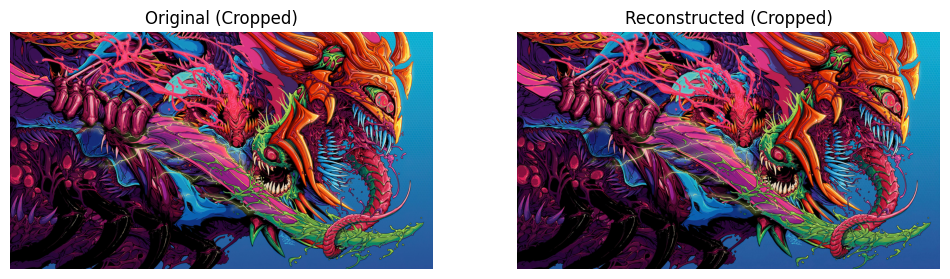

In [19]:
#Convert reconstructed YCbCr to RGB
#Ensure the reconstructed channels are within the valid range [0, 255]
Y_rec_clipped = np.clip(Y_rec, 0, 255)
Cb_rec_clipped = np.clip(Cb_rec, 0, 255)
Cr_rec_clipped = np.clip(Cr_rec, 0, 255)

# YCbCr to RGB conversion (adjusting for the offset of 128 in Cb and Cr)
R_rec = Y_rec_clipped + 1.402 * (Cr_rec_clipped - 128)
G_rec = Y_rec_clipped - 0.344136 * (Cb_rec_clipped - 128) - 0.714136 * (Cr_rec_clipped - 128)
B_rec = Y_rec_clipped + 1.772 * (Cb_rec_clipped - 128)

# Clip the RGB values to the valid range [0, 255] and convert to uint8
rec_img = np.stack([R_rec, G_rec, B_rec], axis=-1)
rec_img = np.clip(rec_img, 0, 255).astype(np.uint8)

#Crop images to the minimum dimensions for comparison and display
min_H = min(img.shape[0], rec_img.shape[0])
min_W = min(img.shape[1], rec_img.shape[1])

img_cropped = img[:min_H, :min_W, :].astype(np.uint8)
rec_cropped = rec_img[:min_H, :min_W, :]


#PSNR
# Calculate PSNR on the cropped original and reconstructed images
mse = np.mean((img_cropped.astype(np.float32) - rec_cropped.astype(np.float32))**2)
if mse == 0:
    psnr = 100 # Infinite PSNR for identical images
else:
    psnr = 20*math.log10(255.0/math.sqrt(mse))
print("PSNR:", psnr)

#Show
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(img_cropped); plt.title("Original (Cropped)"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(rec_cropped); plt.title("Reconstructed (Cropped)"); plt.axis("off")
plt.show()